In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools # Pour créer des iterateurs

import matplotlib.pyplot as plt  # Pour l'affichage d'images
from matplotlib import cm # Pour importer de nouvelles cartes de couleur

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn import metrics

from PIL import Image

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import callbacks

%matplotlib inline

In [3]:
csv_5fam = "/content/gdrive/MyDrive/Colab Notebooks/reduced_dataset_5_families.csv"
df = pd.read_csv(csv_5fam)

folderpath = "/content/gdrive/MyDrive/images_mushroom/"
df['filepath'] = [folderpath + str(df['image_id'][x]) + ".jpg" for x in range(len(df))]

df.head()

,image_id,image_url,family,filepath,label
0,28,http://mushroomobserver.org/images/320/28,Inocybaceae,/content/gdrive/MyDrive/images_mushroom/28.jpg,0
1,86,http://mushroomobserver.org/images/320/86,Physalacriaceae,/content/gdrive/MyDrive/images_mushroom/86.jpg,3
2,87,http://mushroomobserver.org/images/320/87,Physalacriaceae,/content/gdrive/MyDrive/images_mushroom/87.jpg,3
3,126,http://mushroomobserver.org/images/320/126,Omphalotaceae,/content/gdrive/MyDrive/images_mushroom/126.jpg,1
4,128,http://mushroomobserver.org/images/320/128,Omphalotaceae,/content/gdrive/MyDrive/images_mushroom/128.jpg,1


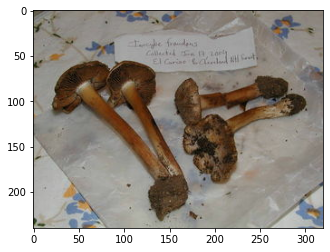

In [8]:
# Just to run a simple test:

im = tf.io.read_file(df['filepath'].iloc[24])
# Décoder l'information en un tensorflow RGB (3 channels).
im = tf.image.decode_jpeg(im, channels=3)

plt.imshow(im);

**Load previously saved model**

In [9]:
data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)
data_train.head()

train_data_generator = ImageDataGenerator(rotation_range=5,
                                          width_shift_range = 0.1,
                                          height_shift_range = 0.05,
                                          zoom_range = 1.1)

test_data_generator = ImageDataGenerator()

batch_size = 32

data_train["label"] = data_train["label"].astype(str)
data_test["label"] = data_test["label"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe = data_train, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')
test_generator = test_data_generator.flow_from_dataframe(dataframe = data_test, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')

new_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/checkpoint_effnet')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Found 13709 validated image filenames belonging to 5 classes.
Found 3428 validated image filenames belonging to 5 classes.


In [10]:
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience = 3,
                                         factor = 0.1,
                                         verbose = 2,
                                         mode = 'min')

early_stopping = callbacks.EarlyStopping(monitor = "val_loss",
                                         patience = 7,
                                         mode = 'min',
                                         verbose = 2,
                                         restore_best_weights= True)

checkpoint = callbacks.ModelCheckpoint(filepath="/content/gdrive/MyDrive/Colab Notebooks/test_save/model_effnetB1_2_20210623.h5",
                                      monitor = 'val_loss',
                                      save_best_only = True,
                                      save_weights_only = False,
                                      mode = 'min',
                                      save_freq = 'epoch')


history = new_model.fit(train_generator, 
                              epochs = 30,
                              steps_per_epoch = len(data_train)//batch_size,
                              validation_data = test_generator,
                              validation_steps = len(data_test)//batch_size,
                              callbacks=[lr_plateau, early_stopping, checkpoint])

Epoch 1/30
428/428 [==============================] - 4715s 11s/step - loss: 0.7493 - accuracy: 0.7052 - val_loss: 0.6549 - val_accuracy: 0.7588


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
428/428 [==============================] - 320s 748ms/step - loss: 0.7396 - accuracy: 0.7140 - val_loss: 0.6521 - val_accuracy: 0.7591
Epoch 3/30
428/428 [==============================] - 322s 750ms/step - loss: 0.7364 - accuracy: 0.7086 - val_loss: 0.6742 - val_accuracy: 0.7585
Epoch 4/30
428/428 [==============================] - 322s 751ms/step - loss: 0.7167 - accuracy: 0.7202 - val_loss: 0.6684 - val_accuracy: 0.7634
Epoch 5/30
428/428 [==============================] - 323s 754ms/step - loss: 0.7085 - accuracy: 0.7191 - val_loss: 0.6641 - val_accuracy: 0.7591

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 6/30
428/428 [==============================] - 324s 756ms/step - loss: 0.6937 - accuracy: 0.7276 - val_loss: 0.6503 - val_accuracy: 0.7696
Epoch 7/30
428/428 [==============================] - 322s 751ms/step - loss: 0.6831 - accuracy: 0.7306 - val_loss: 0.6553 - val_accuracy: 0.7696
Epoch 8/30
428/428 [======================

In [11]:
### Set the path and name you want !
##
#
save_name = "/content/gdrive/MyDrive/Colab Notebooks/test_save/model_effnetB1_final_20210624.h5"
#
##
###


new_model.save(save_name)

## found on stackoverflow
#loaded_model = create_model()
#loaded_model.load_weights(filepath)
#y_pred = loaded.model.<predict_method>(test_set,verbose=<val>)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
X_test_path = data_test['filepath']
X_test = []
for filepath in tqdm(X_test_path):
    # Lecture du fichier
    im = tf.io.read_file(filepath)
    # On décode le fichier
    im = tf.image.decode_jpeg(im, channels=3)
    # Redimensionnement
    im = tf.image.resize(im, size=(256, 256))
    X_test.append([im])
    
X_test = tf.concat(X_test, axis=0)

100%|██████████| 3428/3428 [00:22<00:00, 150.02it/s]


l'accuracy est de : 0.7610851808634772


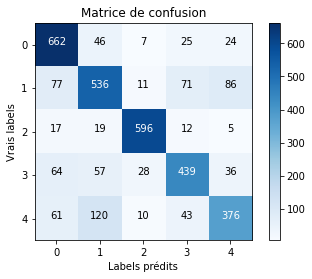

In [ ]:
y_prob = new_model.predict(X_test, batch_size=16)
y_pred = tf.argmax(y_prob, axis = 1).numpy()
y_test = data_test['label'].astype(int)

print("l'accuracy est de :", accuracy_score(y_test, y_pred))
print("le f1 score est de :", f1_score(y_test, y_pred))

cnf_matrix = confusion_matrix(y_test, y_pred)

### Just for the fun !
##
#
num_class = df["label"].nunique()
classes = range(0,num_class)

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()
#
##
###

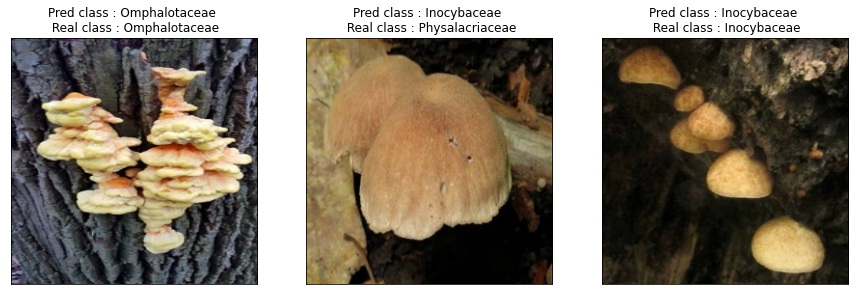

In [ ]:
indices_random = tf.random.uniform([3], 0, len(X_test), dtype=tf.int32)

plt.figure(figsize=(15,7))
for i, idx in enumerate(indices_random):
    plt.subplot(1,3,i+1)
    plt.imshow(tf.cast(X_test[idx], tf.int32))
    plt.xticks([])
    plt.yticks([])
    plt.title('Pred class : {} \n Real class : {}'.format(df.family.unique()[y_pred[idx]], df.family.unique()[y_test.values[idx]]))